# The Handwashing Paradox

In the 1840s, a junior doctor named Ignaz Semmelweis working at the Vienna General Hospital in Austria noticed a strange problem: in its two maternity clinics, one had a far higher death rate from an unknown fever. He suspected a deeper problem and was determined to find the answer. I will now step into his shoes and use modern data analysis tools (pandas, vizualization, sql, and statistics) to investigate this historical case and validate his discovery.


### Dr. Ignaz Semmelweis
<img src="../gifs/semmelwies.png" width="600">

In [ ]:
# Connects Google Colab to your Google Drive to access project files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Loading the Data

We load the annual and monthly hospital records into pandas and prepare a `mortality_rate` column (deaths ÷ births × 100) so we can compare clinics and track trends.


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# File paths (your folder: HandWashParadox)
annual_path  = "/content/drive/My Drive/HandWashParadox/annual_deaths.csv"
monthly_path = "/content/drive/My Drive/HandWashParadox/monthly_deaths.csv"

# Load datasets (only once) and parse monthly dates
annual_df  = pd.read_csv(annual_path)
monthly_df = pd.read_csv(monthly_path, parse_dates=['date'])

# Add mortality_rate (%) columns
annual_df['mortality_rate']  = (annual_df['deaths'] / annual_df['births']) * 100
monthly_df['mortality_rate'] = (monthly_df['deaths'] / monthly_df['births']) * 100

# Quick peek to confirm everything loaded correctly
print("Annual — first rows")
display(annual_df.head())

print("\nMonthly — first rows")
display(monthly_df.head())

Annual — first rows


,year,births,deaths,clinic,mortality_rate
0,1841,3036,237,clinic 1,7.806324
1,1842,3287,518,clinic 1,15.759051
2,1843,3060,274,clinic 1,8.954248
3,1844,3157,260,clinic 1,8.235667
4,1845,3492,241,clinic 1,6.901489



Monthly — first rows


,date,births,deaths,mortality_rate
0,1841-01-01,254,37,14.566929
1,1841-02-01,239,18,7.531381
2,1841-03-01,277,12,4.332130
3,1841-04-01,255,4,1.568627
4,1841-05-01,255,2,0.784314


## 2. Annual Mortality Rates by Clinic  

To start the investigation, we compare the annual mortality rates between the two maternity clinics.  
This gives us a high-level view of the problem Semmelweis observed and helps identify where deaths were concentrated.  


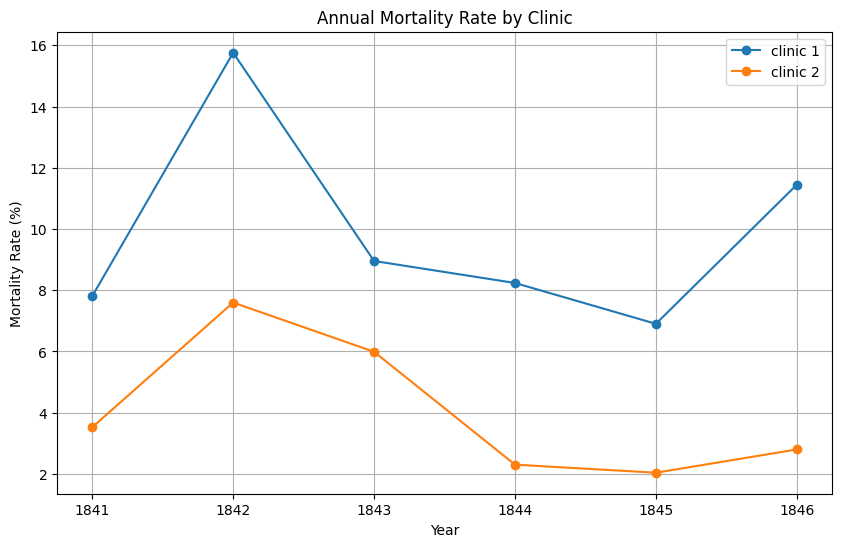

In [ ]:
# Plot annual mortality rates by clinic
plt.figure(figsize=(10,6))

for clinic in annual_df['clinic'].unique():
    subset = annual_df[annual_df['clinic'] == clinic]
    plt.plot(subset['year'], subset['mortality_rate'], marker='o', label=clinic)

plt.title("Annual Mortality Rate by Clinic")
plt.xlabel("Year")
plt.ylabel("Mortality Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

## 3. Monthly Mortality Trends

While the annual data highlights differences between the two clinics, it hides the month-to-month fluctuations.  
By visualizing the mortality rate on a monthly scale (1841–1849), we can capture the finer details and set the stage for spotting turning points in the data.


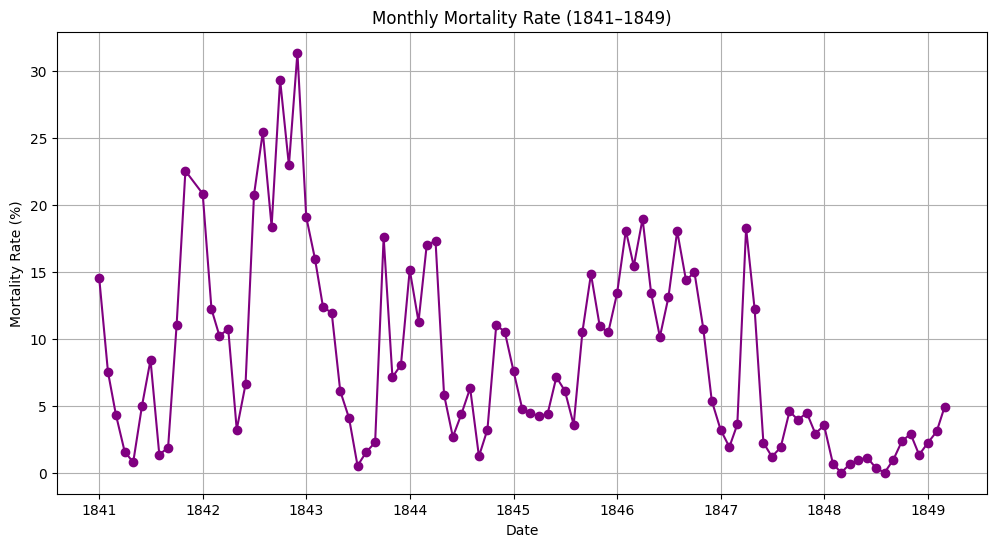

In [ ]:
# Plot monthly mortality rate across the full timeline
plt.figure(figsize=(12,6))
plt.plot(monthly_df['date'], monthly_df['mortality_rate'], marker='o', color='purple')

plt.title("Monthly Mortality Rate (1841–1849)")
plt.xlabel("Date")
plt.ylabel("Mortality Rate (%)")
plt.grid(True)
plt.show()

## 4. The Turning Point: Introduction of Handwashing

Semmelweis introduced mandatory handwashing with a chlorinated lime solution in **mid-1847**.  
To test its impact, we mark this intervention on the monthly mortality timeline and observe whether the death rates declined after this change.


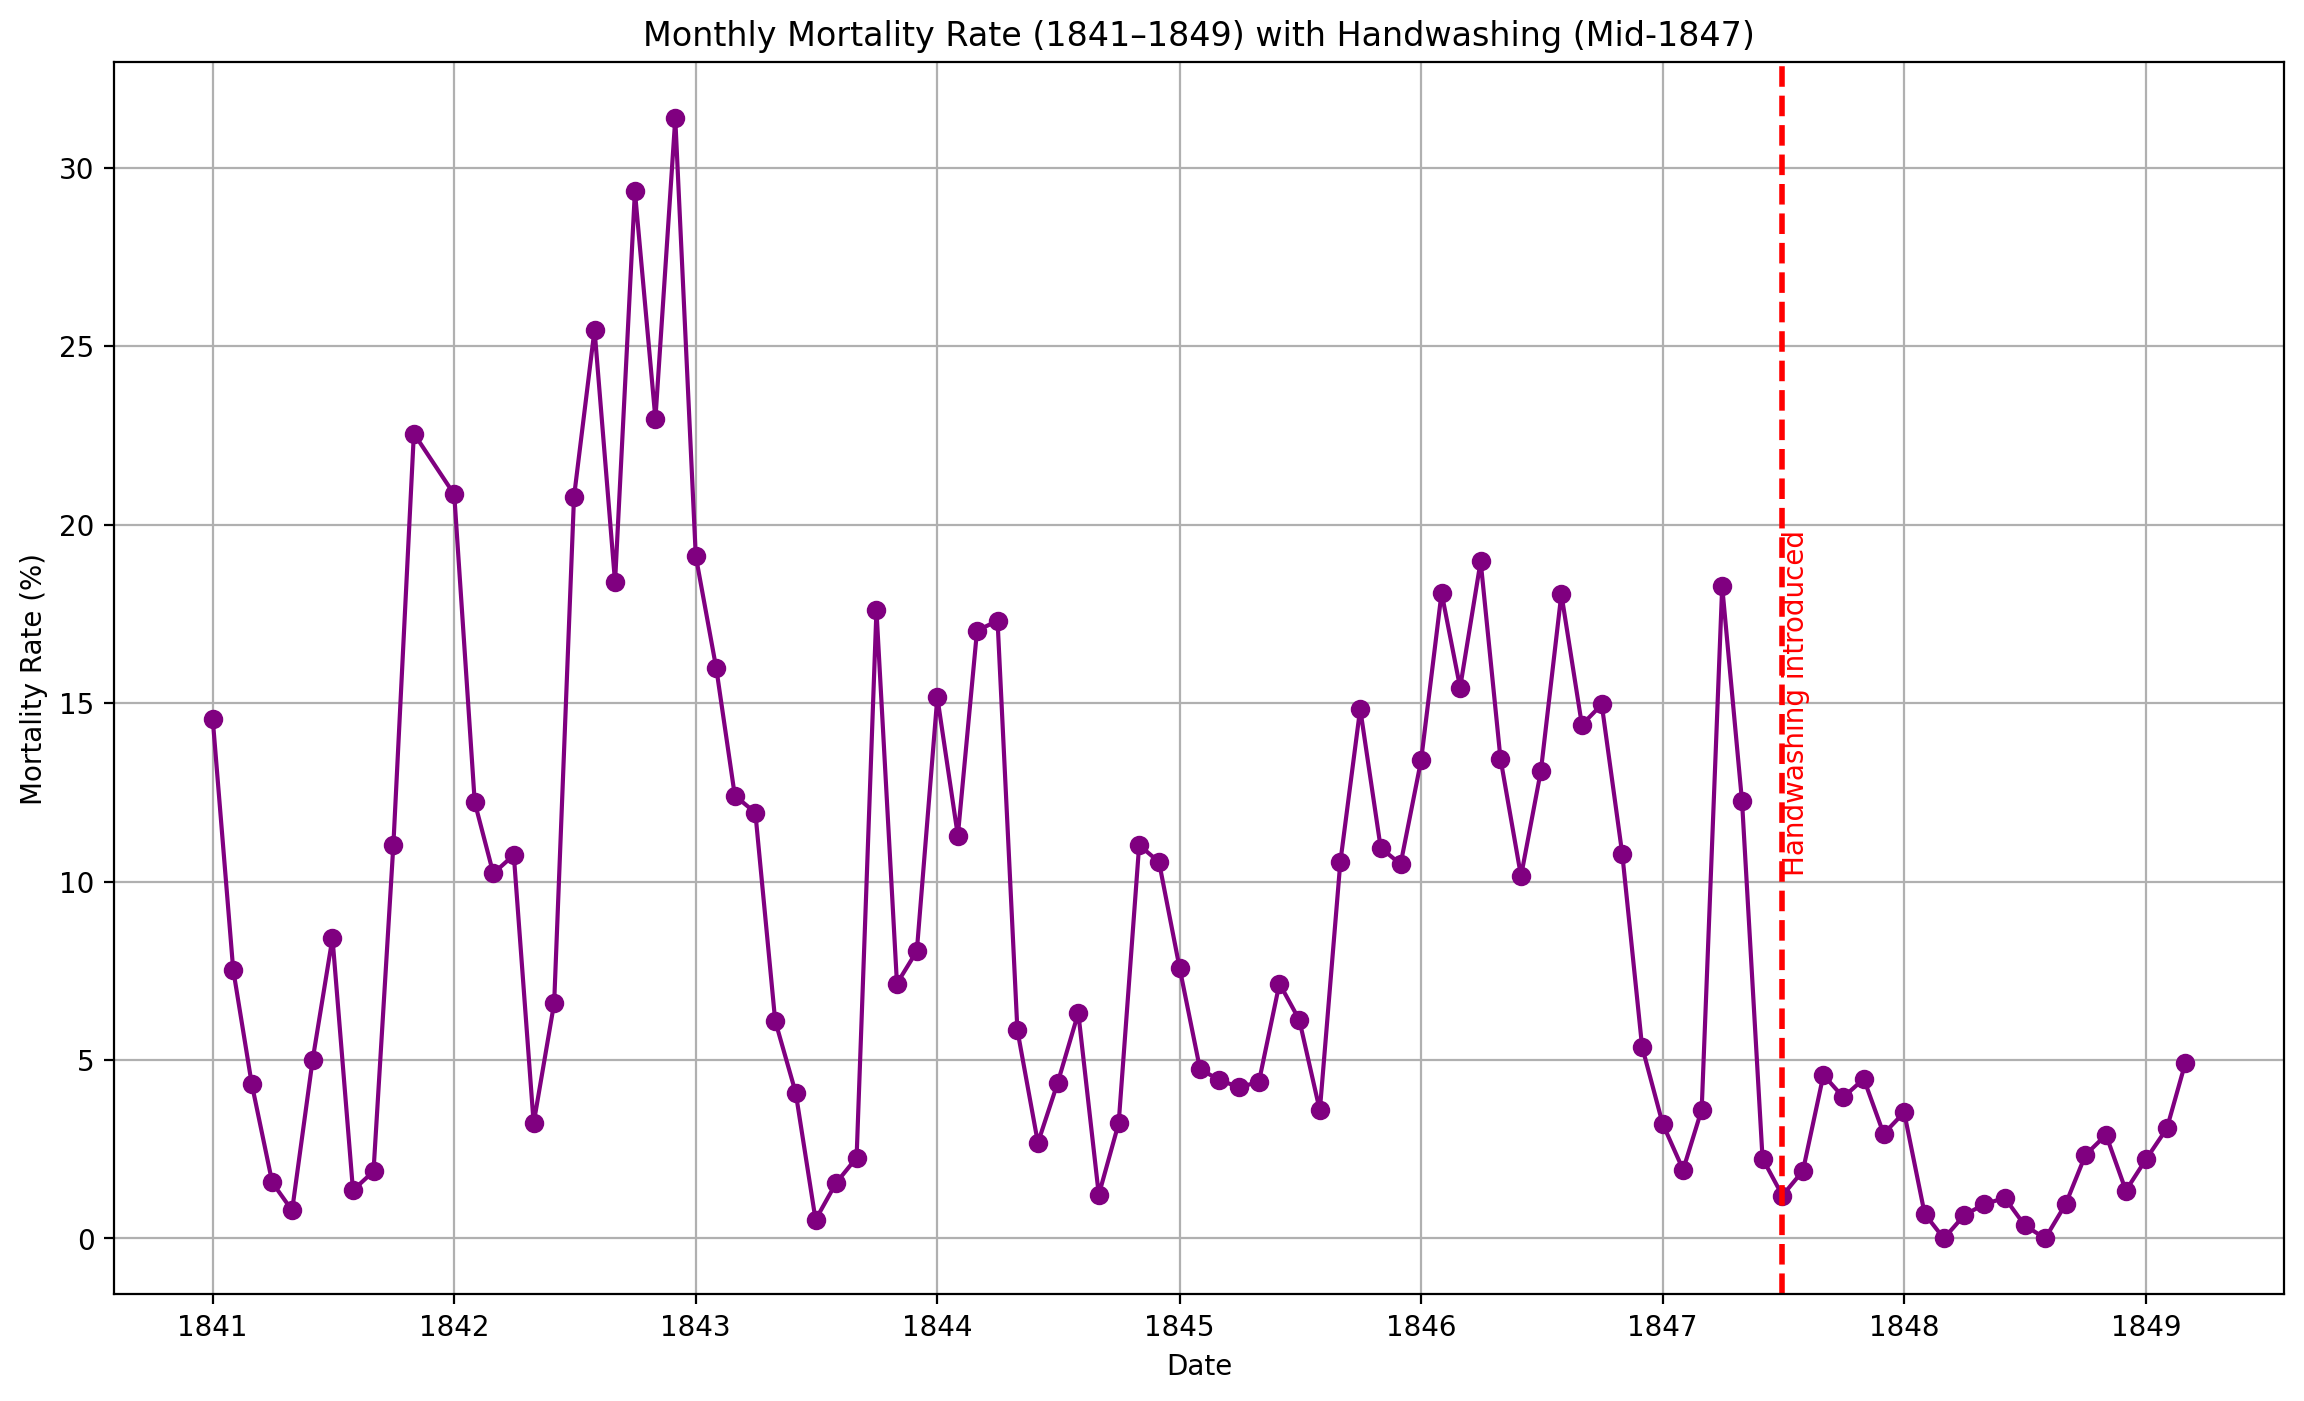

In [ ]:
# Creates a new plot figure with specified size and resolution
plt.figure(figsize=(14,8), dpi=200)

# Plots monthly mortality rate
plt.plot(monthly_df['date'], monthly_df['mortality_rate'], marker='o', color='purple')

# Adds vertical red dashed line for handwashing introduction
plt.axvline(pd.to_datetime('1847-07-01'), color='red', linestyle='--', linewidth=2)
plt.text(pd.to_datetime('1847-07-01'), 15, 'Handwashing introduced', color='red', rotation=90, va='center')

# Sets title and labels
plt.title('Monthly Mortality Rate (1841–1849) with Handwashing (Mid-1847)')
plt.xlabel('Date')
plt.ylabel('Mortality Rate (%)')
plt.grid(True)

# Displays plot
plt.show()

## 5. Before vs After Handwashing (SQL Analysis)

Using SQL on the monthly hospital records, we measure how mortality changed after the introduction of handwashing in July 1847.  
This gives us clear numbers: total births, deaths, mortality rates, and an estimate of lives saved.




In [ ]:
import sqlite3

# Connect to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Save monthly_df as SQL table
monthly_df.to_sql('monthly_data', conn, index=False, if_exists='replace')

cur = conn.cursor()

# Totals before handwashing (before July 1847)
cur.execute("""
SELECT SUM(births), SUM(deaths), (SUM(deaths)*100.0)/SUM(births)
FROM monthly_data
WHERE date < '1847-07-01'
""")
before = cur.fetchone()
print("Before handwashing (births, deaths, mortality%):", before)

# Totals after handwashing (July 1847 onwards)
cur.execute("""
SELECT SUM(births), SUM(deaths), (SUM(deaths)*100.0)/SUM(births)
FROM monthly_data
WHERE date >= '1847-07-01'
""")
after = cur.fetchone()
print("After handwashing (births, deaths, mortality%):", after)

# Estimate lives saved
expected_deaths_after = after[0] * (before[2]/100.0)
lives_saved = expected_deaths_after - after[1]
print("Estimated lives saved by handwashing:", round(lives_saved))


Before handwashing (births, deaths, mortality%): (19839, 2066, 10.41383134230556)
After handwashing (births, deaths, mortality%): (6327, 136, 2.149517938991623)
Estimated lives saved by handwashing: 523


## 6. Statistical Validation (T-test)

To strengthen the analysis, we apply a statistical test.  
Using a two-sample T-test, we check whether the difference in mortality rates before and after July 1847 is statistically significant.


In [ ]:
from scipy.stats import ttest_ind

# Split mortality rates into before and after handwashing
before_rates = monthly_df[monthly_df['date'] < '1847-07-01']['mortality_rate']
after_rates  = monthly_df[monthly_df['date'] >= '1847-07-01']['mortality_rate']

# Perform two-sample independent t-test
t_stat, p_val = ttest_ind(before_rates, after_rates)

print("T-statistic:", t_stat)
print("P-value:", p_val)

T-statistic: 5.307992887371079
P-value: 7.131547432636908e-07


## 7. Visual Summary and Project Wrap-Up

To clearly summarize the findings, we compare the **average monthly mortality rates** before and after the introduction of handwashing.  
This final chart and summary highlight the impact of Semmelweis’ handwashing intervention in reducing maternal mortality.



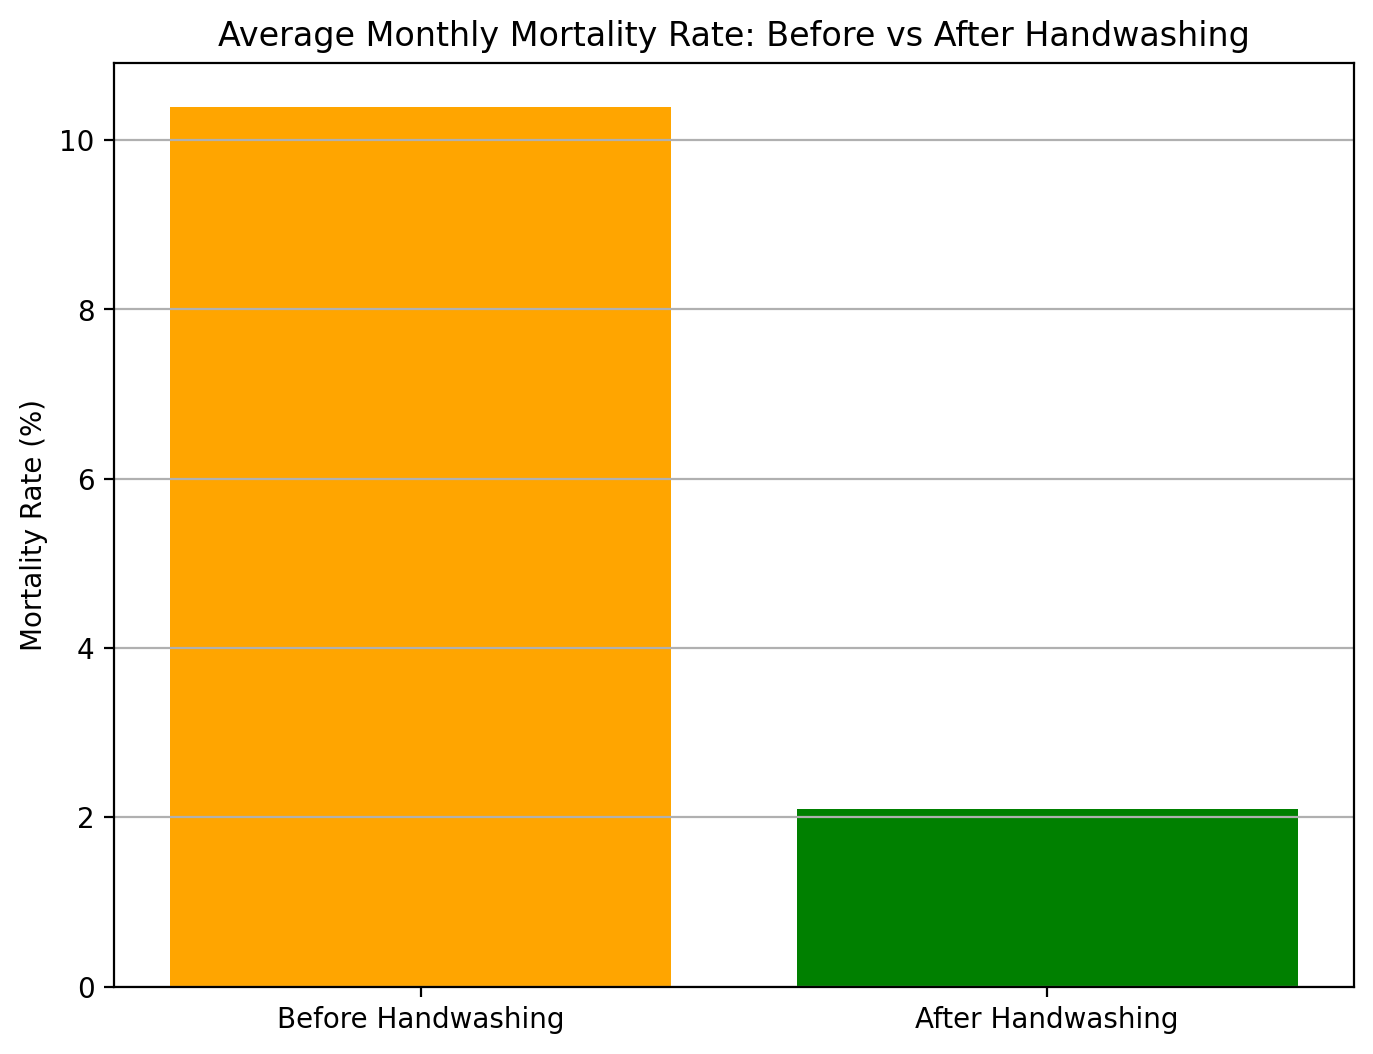

In [ ]:
# Prepare summary data
before = monthly_df[monthly_df['date'] < '1847-07-01']
after = monthly_df[monthly_df['date'] >= '1847-07-01']

summary = pd.DataFrame({
    'Period': ['Before Handwashing', 'After Handwashing'],
    'Total Births': [before['births'].sum(), after['births'].sum()],
    'Total Deaths': [before['deaths'].sum(), after['deaths'].sum()],
    'Average Mortality Rate (%)': [before['mortality_rate'].mean(), after['mortality_rate'].mean()]
})

# Plot bar chart for Average Mortality Rate
plt.figure(figsize=(8,6), dpi=200)
plt.bar(summary['Period'], summary['Average Mortality Rate (%)'], color=['orange', 'green'])
plt.title('Average Monthly Mortality Rate: Before vs After Handwashing')
plt.ylabel('Mortality Rate (%)')
plt.grid(axis='y')
plt.show()


## 8. Conclusion & Insights  

This project demonstrates how **data analysis can uncover powerful insights with real-world impact**.  

- **Clear Evidence:** Mortality rates dropped from **~10% before handwashing** to **~2% after**, saving an estimated **523 lives**.  
- **Statistical Proof:** A t-test confirmed this drop was **highly significant** (p ≈ 7e-07).  
- **Broader Lesson:** Even in the 1840s, careful data collection and analysis guided life-saving medical practices.  

Semmelweis himself reached this conclusion through observation and record-keeping, and he introduced handwashing as a preventive measure.  
With modern tools, we can now validate his insight more convincingly and show just how powerful that simple intervention was.  


### A sketch of Ignaz Semmelweis washing his hands in chlorinated lime water before operating. Photo: Bettmann / Contributor
<img src="../gifs/HandWashSketch.png" width="600">